<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 14: Inferencia Bayesiana, Introducción </span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

# Introducción a la Inferencia Bayesiana

La inferencia bayesiana consiste en actualizar nuestras creencias sobre parámetros desconocidos
a partir de los datos observados.

El fundamento es el **Teorema de Bayes**:

\begin{equation}
p(\theta \mid y) \propto p(y \mid \theta)\, p(\theta)
\end{equation}

Donde:

- **p(θ)** es el **prior** (creencias previas sobre el parámetro).
- **p(y | θ)** es la **verosimilitud**, un modelo estadístico para los datos.
- **p(θ | y)** es el **posterior**, lo que creemos después de ver los datos.

La idea clave:  
**No estimamos un solo valor**, sino que obtenemos **una distribución completa** para cada parámetro, incluyendo incertidumbre.

En la práctica moderna usamos métodos numéricos como **MCMC** (Markov Chain Monte Carlo), y PyMC proporciona implementaciones eficientes como NUTS (No-U-Turn Sampler).


In [1]:
# Librerías 

import os

# (opcional, sólo para estar seguros de no arrastrar cosas viejas)
os.environ.pop("PYTENSOR_FLAGS", None)

import pytensor
# Desactivar compilador C/C++
pytensor.config.cxx = ""
pytensor.config.mode = "FAST_COMPILE"  # para que no intente optimizaciones pesadas

import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# Configuración opcional
%config InlineBackend.figure_format = 'retina'

rng = np.random.default_rng(42)

## Ejemplo 1: Modelo Beta–Binomial (Estimación de una proporción)

Supongamos que queremos estimar la probabilidad de éxito \( p \)
de un proceso binomial (por ejemplo, tasa de conversión, éxito/fracaso, etc.).

Observamos:

- $n$ ensayos
- $x$ éxitos

Modelo:

1. **Prior**:
\begin{equation}
p \sim \text{Beta}(\alpha, \beta)
\end{equation}

2. **Verosimilitud**:
\begin{equation}
x \sim \text{Binomial}(n, p)
\end{equation}

El posterior es:

\begin{equation}
P(p \mid x) \sim \text{Beta}(\alpha + x, \beta + n - x)
\end{equation}

Pero usaremos PyMC para estimarlo mediante MCMC.

### ¿Por qué usamos la distribución beta y binomial?

Cuando el fenómeno que queremos modelar tiene dos posibles resultados (éxito o fracaso), y repetimos el experimento $n$ veces, el número total de éxitos $x$ sigue una distribución binomial $x \sim \rm{Binomial}(n,p)$. La verosimilitud describe la probabilidad de observar los datos $x$ dado un cierto valor de $p$, $p(x|p) = {}_nC_x p^x (1-p)^{n-x}$.

Como el parámetro $p$ sólo puede tomar valores entre 0 y 1, una distribución natural para expresar incertidumbre sobre $p$ antes de ver los datos es la distribución Beta, definida en el intervalo $[0,1]$, $p \sim \rm{Beta} (\alpha, \beta)$. Sus parámetros $\alpha$ y $\beta$ podrían interpretarse como **pseudoconteos**, donde,

* $\alpha - 1$: número de éxitos observados antes de los datos.
* $\beta - 1$: número de fracasos observados antes de los datos.

De esta forma, un ejemplo podría ser $\rm{Beta}(1,1)$, que sería un prior uniforme (sin información previa). Otro sería $\rm{Beta}(2,5)$, un prior más concentrado hacia valores pequeños de $p$.

El gran beneficio de usar una distribución Beta como prior con una Binomial como verosimilitud es que forman lo que se llama un **par conjugado**, donde el posterior también es una distribución Beta. Esto simplifica mucho la inferencia y tiene una interpretación intuitiva,

\begin{equation}
P(p \mid x,n) \propto p(x|p)p(p) \Rightarrow P(x|x,n) \sim \rm{Beta}(\alpha + x, \beta + n -x)
\end{equation}

Es decir, estamos actualizando los **pseudoconteos** sumando los nuevos datos observados.

Cada vez que observamos más ensayos, entonces el posterior se concentra más alrededor del valor real de $p$, y la incertidumbre (varianza) de la distribución Beta posterior se reduce.


In [2]:
# xcode-select --install
# export SDKROOT=$(xcrun --sdk macosx --show-sdk-path)
# ls "$SDKROOT/usr/include/stdio.h"
# export CPATH="$SDKROOT/usr/include:$CPATH"

In [3]:
# Número de ensayos (n) y probabilidad real (no conocida en la práctica)
n = 80
p_true = 0.30

# Éxitos observados
x = rng.binomial(n=n, p=p_true)

n, p_true, x

(80, 0.3, 27)

In [4]:
# Definición del modelo en PyMC

with pm.Model() as beta_binom_model:
    
    # Prior no informativo: Beta(1,1) equivale a uniforme en [0,1]
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )

idata

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

PyMC está haciendo, de manera muy general, lo siguiente,

1. Toma el modelo que definiste, en este caso,
   * Prior: $p \sim \rm{Beta}(1,1)$
   * Verosimilitud: $x \sim \rm{Binomial}(n,p)$, con `observed=x`. Es decir, los datos que viste son $x$ éxitos en $n$ ensayos.
2. Construye la función posterior
   Usando el teorema de Bayes $P(p|x) \propto P(x|p)P(p)$, que sabemos que analíticamente el posterior es  $\sim \rm{Beta}(\alpha + x, \beta + n -x$. PyMC no sabe esto, pero lo hace aproximando el posterior *numéricamente*.
3. Se inicializa el sampler NUTS
   `Initializing NUTS` significa que PyMC eligió el sampler NUTS (No-U-Turn Sampler), una variante eficiente de Hamiltonian Monte Carlo (otra variante sería Metropolis-Hastings). Durante esta fase se ajusta automáticamente:
   * El tamaño de paso (step size)
   * Matriz de masas (masa/escala de los parámetros)
   * Algunos valores iniciales razonables
4. Fase de `tune`
   Los primeros `tune`pasos por cadena (aquí 1000) no ser guardan en el posterior. Solo se usan para que NUTS aprenda una buena escala de pasos y se adapte a la geometría del posterior. Esto reduce la autocorrelación y mejora la eficiencia de las muestras posteriores.
5. Fase de muestreo `draws`
   Después de `tune`, PyMC genera `draw`muestras por cadena (aquí 2000) de la distribución posterior de $p$. En total se termina con un número total de muestras = chains X draws = 4 X 2000 = 8000. Todas estas muestras quedan guardadas en la variable `idata` (un objeto `InferenceData` de ArviZ).

Los parámetros de `pm.sample` fueron los siguientes:

* `draws`: cuántas muestras útilies quieres de la d. posterior. Más muestras -> merjor aproximación (pero más tiempo)
* `tune`: número de iteraciones para que NUTS se "acomode" o "termalice". No se usan para inferencia.
* `chains`: cuántas cadenas MCMC se corren en paralelo. Sirve para checar si todas convergen a la misma distribución.
* `target_accept`: controla la agresividad del sampler. Valores típicos rondan los 0.8-0.9, si se tiene mucha divergencia, entonces valores entre 0.9 - 0.95 suele ayudar.
 

In [6]:
az.summary(idata, var_names=['p'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.341,0.052,0.249,0.444,0.001,0.001,2564.0,4137.0,1.0


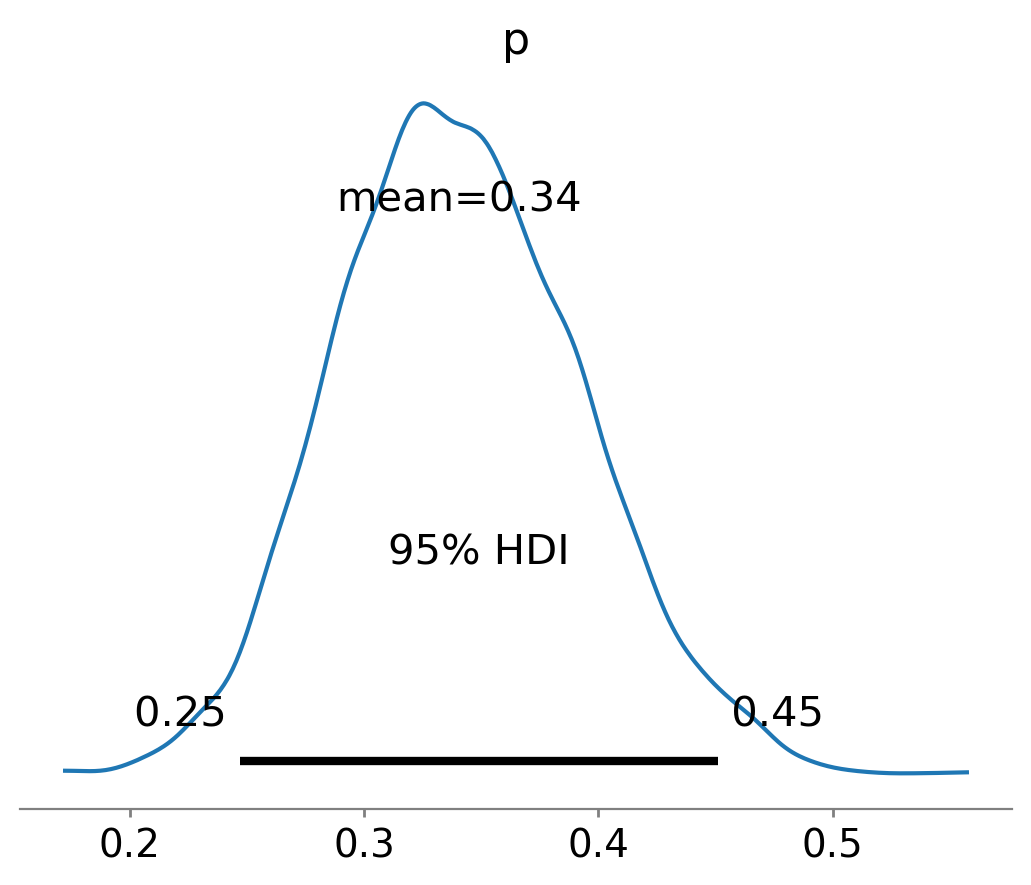

In [8]:
az.plot_posterior(idata, var_names=["p"], hdi_prob=0.95)
plt.show()

Eso te da una tabla con, típicamente:

* `mean`: media posterior de $p$.
* `sd`: desviación estándar posterior.
* `hdi_3%, hdi_97%` (o similar): intervalo de credibilidad (por ejemplo 94% o 95% según config).
* `ess_bulk, ess_tail`: effective sample size en el cuerpo y colas de la distribución (muestras efectivas independientes).
* `r_hat`: diagnóstico de convergencia ($\hat{R}$ de Gelman–Rubin). Valores cercanos a 1 indican buena convergencia.

Para el modelo Beta–Binomial esperas que la **media posterior** esté cerca de $x/n$ (o de la media de la Beta posterior analítica). El intervalor HDI representa la incertidumbre sobre $p$, es decir, "Dado el modelo y los datos, hay un 95% de probabilidad de que $p$ se encuentre en este intervalo."


## Buenas prácticas en inferencia bayesiana

La inferencia bayesiana con PyMC no consiste sólo en ejecutar un sampler MCMC, también implica varificar la calidad de las muestras, entender las decisiones del modelado y evaluar si el modelo realmente explica los datos. Las prácticas estándar son las siguientes,

1. Verifica la convergencia de las cadenas

   Los samplers MCMC generan muestras **correlacionadas**, y pueden atascarse si el espacio de parámetros es complicado. Entonces, es imprescindible verificar algunos valores,
   * Estadístico $\hat{R}$. Mide si las cadenas independientes convergen al mismo posterior. Si $\hat{R} \approx 1$ entonces va bien, mientras que sea $> 1.01$ muestra una posible falta de convergencia, o $>1.1$ muestra que el muestreo no es confiable.
2. ESS (Efective Sample Size) Debido a la autocorrelación del muestreo, el número de muestras "útiles" es menor que el número `draws` real. `ESS_bulk` se usa para la mayor parte del posterior mientras que `ESS_tail` para las colas del mismo. En general, tener `ESS_bulk`>400 es recomendable, mientras que `ESS_tail`>100 ayuda a describir bien las colas.
3. Podemos también verificar que las fráficas de las cadena a través de las iteraciones siguen un comportamiento de "ruido".

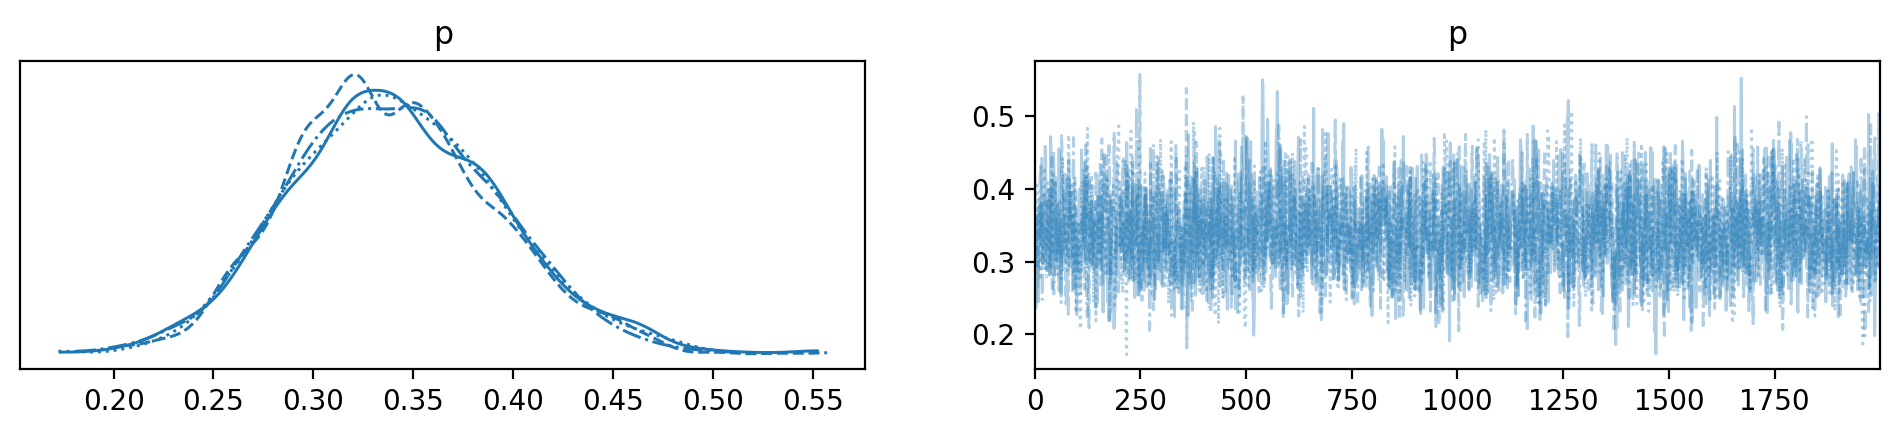

In [9]:
az.plot_trace(idata)
plt.show()

4. Evaluar la sensibilidad al prior

   También se verifica qué tanto influye el prior en el resultado. Ejemplo: cambiar la distribución Beta elegida.

In [10]:
with pm.Model() as beta_binom_model:
    
    # Prior informativo: Beta(2,5)
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata2 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )

idata2

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

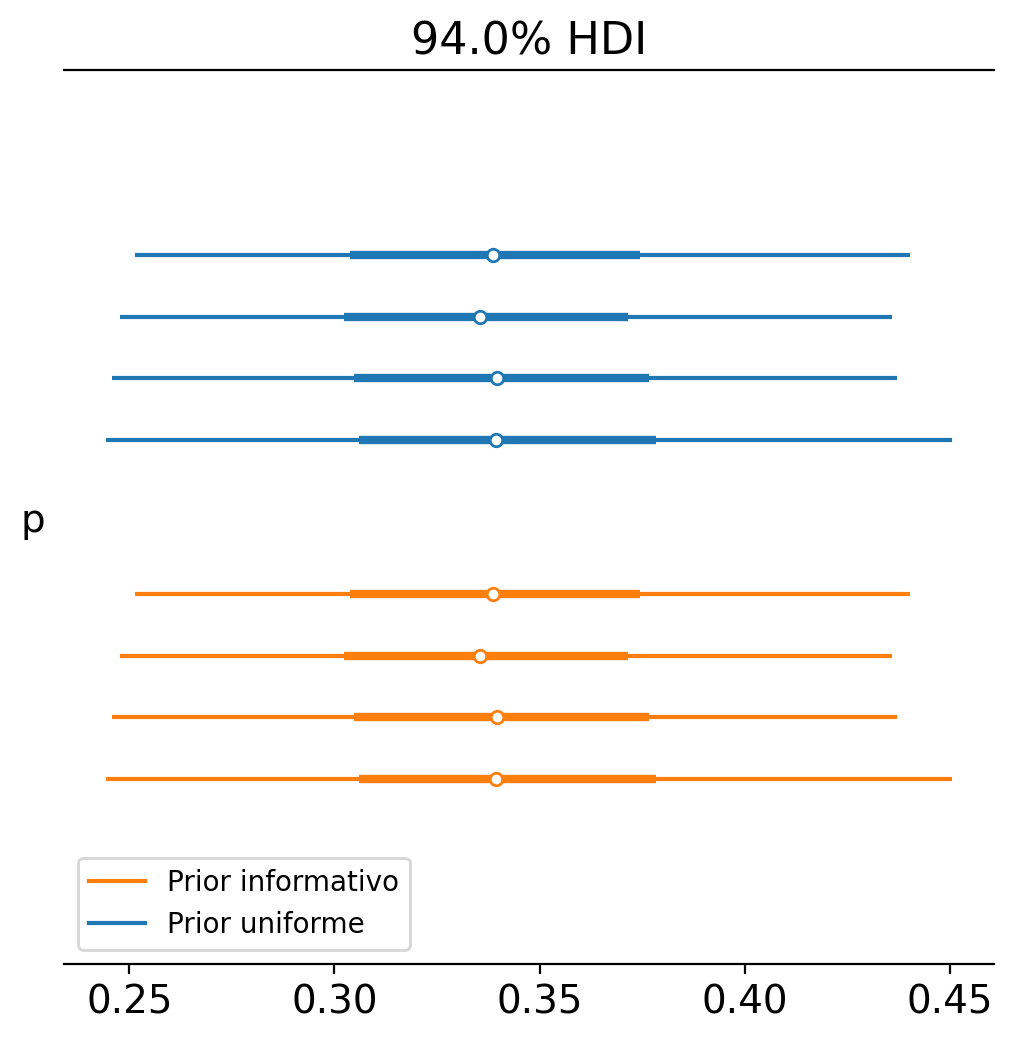

In [11]:
az.plot_forest([idata, idata2], model_names=["Prior uniforme", "Prior informativo"])
plt.show()

Si los prior hacen cambiar mucho al posterior quizá necesites más datos o el prior actual es demasiado fuerte.

In [13]:
# Cuando tienes varios modelos (con varias verosimilitudes o diferente priors)
# LOO (Leave one out CV) estima qué tan bien predice el modelo datos nuevos

#az.loo(idata)
#az.waic(idata)

#az.compare({"modelo1": idata1, "modelo2": idata2})

### Posterior Predictive Checks (PPC)

Los **PPC** evalúan si el modelo es capaz de generar datos similares a los observados. Al comparar las distribuciones, si los datos observados caen fuera de lo que el modelo predice, la estructura del modelo puede ser incorrecta, o la verosimilitud podría no ser adecuada, o podría haber outliers.

In [15]:
with beta_binom_model:
    ppc = pm.sample_posterior_predictive(idata)

Sampling: [obs]


Output()

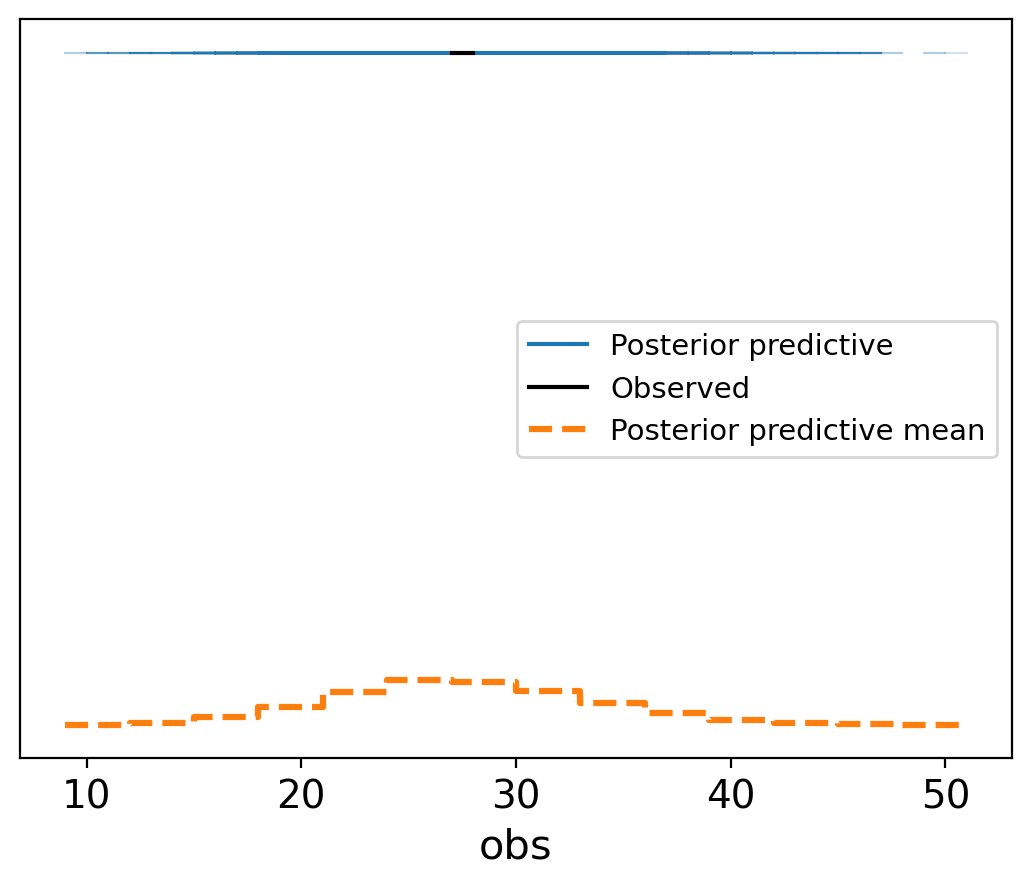

In [16]:
az.plot_ppc(ppc)
plt.show()

Como últimas recomendaciones, si las unidades de tus parámetros son enormes (ejemplo, miles), el sampler podría tardar más, así que la recomendación sería estandarizar las variables o escoger priors realistas.

Otra cosa a considerar en inferencia bayesiana. Una propiedad importante es que entre más datos, el prior tiene una menor importancia. Es decir, 

\begin{equation}
\rm Posterior \approx Verosimilitud \quad si \ n \ es \ grande
\end{equation}

Es decir, cuando tienes muchos datos, el prior importa poco y el posterior estará dominado por los datos. En contraste, mientras tienes pocos datos, el posterior puede depender fuertemente del prior, lo cual tiene cierto sentido, pues a poca evidencia el prior debería importar mucho más.

## Ejericios

* Cambiar el prior.
* Ajustar el modelo y comparar: posterior, invervalos HDI, posterior predictive, y qué tan rápido "domina" la evidencia cuando $n$ crece.

In [17]:
with pm.Model() as beta_binom_model_1:
    
    # Prior no informativo: Beta(1,1) equivale a uniforme en [0,1]
    p = pm.Beta("p", alpha=1, beta=1)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata1 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )

idata1

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
with pm.Model() as beta_binom_model_2:
    
    # Prior informativo: Beta(2,5), favorece pequeños valores de p
    # Prior informativo: Beta(10,10), prior concentrado alrededor de 0.5
    # Prior informativo: Beta(0.5,0.5), prior en forma de U (favorece extremos)
    
    p = pm.Beta("p", alpha=2, beta=5)
    
    # Verosimilitud: datos observados
    obs = pm.Binomial("obs", n=n, p=p, observed=x)
    
    # Muestreo MCMC con NUTS
    idata2 = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )

idata2

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/ds_env/lib/python3.10/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data